In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.python.keras.optimizers import Adadelta, Nadam
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.utils import multi_gpu_model, plot_model
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.preprocessing import image
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
import cv2
from multiclassunet import Unet
from dilatednet import DilatedNet
import tqdm
import time
import json
from tensorflow.python.keras.utils import Sequence
from moviepy.editor import VideoFileClip, ImageSequenceClip

In [2]:
unet = Unet(256, 256, 66, 64)
unet.load_weights('unet.h5')

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [3]:
with open('config.json', 'r') as f:
    config = json.load(f)
labels = config['labels']
color_map = {}
for label in labels:
    color_map[label['readable']] = label['color']
label_list = sorted(color_map.keys())
id_to_color = {v:color_map[k] for v,k in enumerate(label_list)}
def pipeline(image, video=True):
    alpha = 0.6
    dims = image.shape
    x = cv2.resize(image, (256, 256))
    x = np.float32(x)/255.
    z = unet.predict(np.expand_dims(x, axis=0))
    z = np.squeeze(z)
    z = cv2.resize(z, (dims[1], dims[0]))
    y = np.argmax(z, axis=2)
    
    img_color = image.copy()   
    for i in np.unique(y):
        img_color[y==i] = id_to_color[i]
    colored_mask = img_color.copy()
    cv2.addWeighted(image, alpha, img_color, 1-alpha, 0, img_color)
    if video:
        return img_color
    return img_color, colored_mask

In [ ]:
clip = VideoFileClip('delhi.mp4')
res = clip.fl_image(pipeline)
res.write_videofile('delhi_out.mp4', audio=False)

[MoviePy] >>>> Building video delhi_out.mp4
[MoviePy] Writing video delhi_out.mp4


 35%|███▍      | 4998/14473 [13:04<24:47,  6.37it/s]

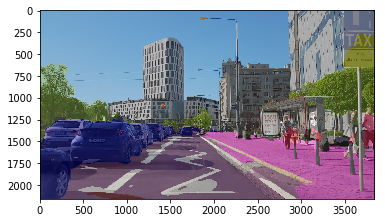

In [10]:
plt.imshow(pipeline(clip.get_frame(100)))

In [8]:
%%HTML
<video width="512" height="288" controls>
  <source src="karol_out.mp4.mp4" type="video/mp4">
</video>

In [4]:
test_dir = 'images'
image_list = os.listdir(test_dir)
print(f'{len(image_list)} frames found')

5000 frames found


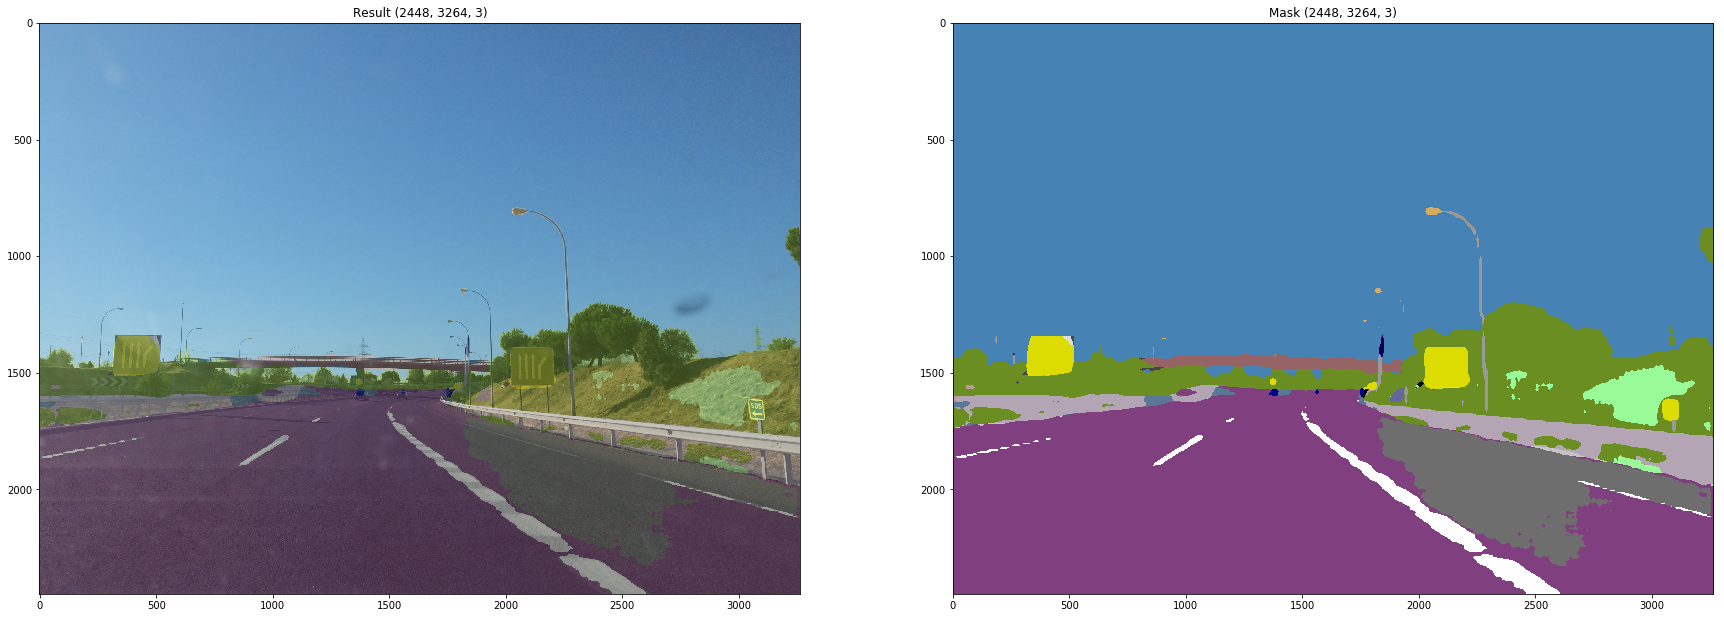

In [5]:
i = 1
test = image.load_img(f'{test_dir}/{image_list[i]}')
test = image.img_to_array(test)
result, mask = pipeline(test)
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(121)
ax.set_title(f'Result {result.shape}')
ax.imshow(result/255.)

ax2 = fig.add_subplot(122)
ax2.set_title(f'Mask {mask.shape}')
ax2.imshow(mask/255.)

In [ ]:
for folder in ['stuggart00', 'stuggart01', 'stuggart02']:
    print(f'loading video {folder}')
    clip = ImageSequenceClip(f'outputs/{folder}/', fps=18, load_images=True)
    print(f'Successfully loaded video {folder}')
    clip.write_videofile(f'outputs/videos/{folder}.mp4')
    print(f'Successfully created video {folder}')